In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprice_data = pd.read_sql_query('select * from houseprices', con= engine)
engine.dispose()

houseprice_data.info()
houseprice_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


Here we have a data set with many possible features, but mostly continous variables, and a few categorical ones. Most of them have full values, but some have nulls or are missing values. Lets see if we can fill in the values by separating the numerical data from the categorical data

In [0]:
numerical = []
non_numerical = []
for col in houseprice_data:
  if houseprice_data[col].dtypes == 'object':
    non_numerical.append(col)
  else:
    numerical.append(col)
if (len(numerical) + len(non_numerical)) == 81:
  print('Sucessfully separated')

Sucessfully separated


Now that the data has been split into categorical and numerical data, we will now fill in the gaps for the numerical data.

In [0]:
for col in numerical:
  if houseprice_data[col].count() < 1460:
    houseprice_data.loc[:,col] = houseprice_data.loc[:,col].interpolate()
houseprice_data[numerical].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   lotfrontage    1460 non-null   float64
 3   lotarea        1460 non-null   int64  
 4   overallqual    1460 non-null   int64  
 5   overallcond    1460 non-null   int64  
 6   yearbuilt      1460 non-null   int64  
 7   yearremodadd   1460 non-null   int64  
 8   masvnrarea     1460 non-null   float64
 9   bsmtfinsf1     1460 non-null   int64  
 10  bsmtfinsf2     1460 non-null   int64  
 11  bsmtunfsf      1460 non-null   int64  
 12  totalbsmtsf    1460 non-null   int64  
 13  firstflrsf     1460 non-null   int64  
 14  secondflrsf    1460 non-null   int64  
 15  lowqualfinsf   1460 non-null   int64  
 16  grlivarea      1460 non-null   int64  
 17  bsmtfullbath   1460 non-null   int64  
 18  bsmthalf

All the missing values have been eliminated. We will now do visualizations for the numerical data

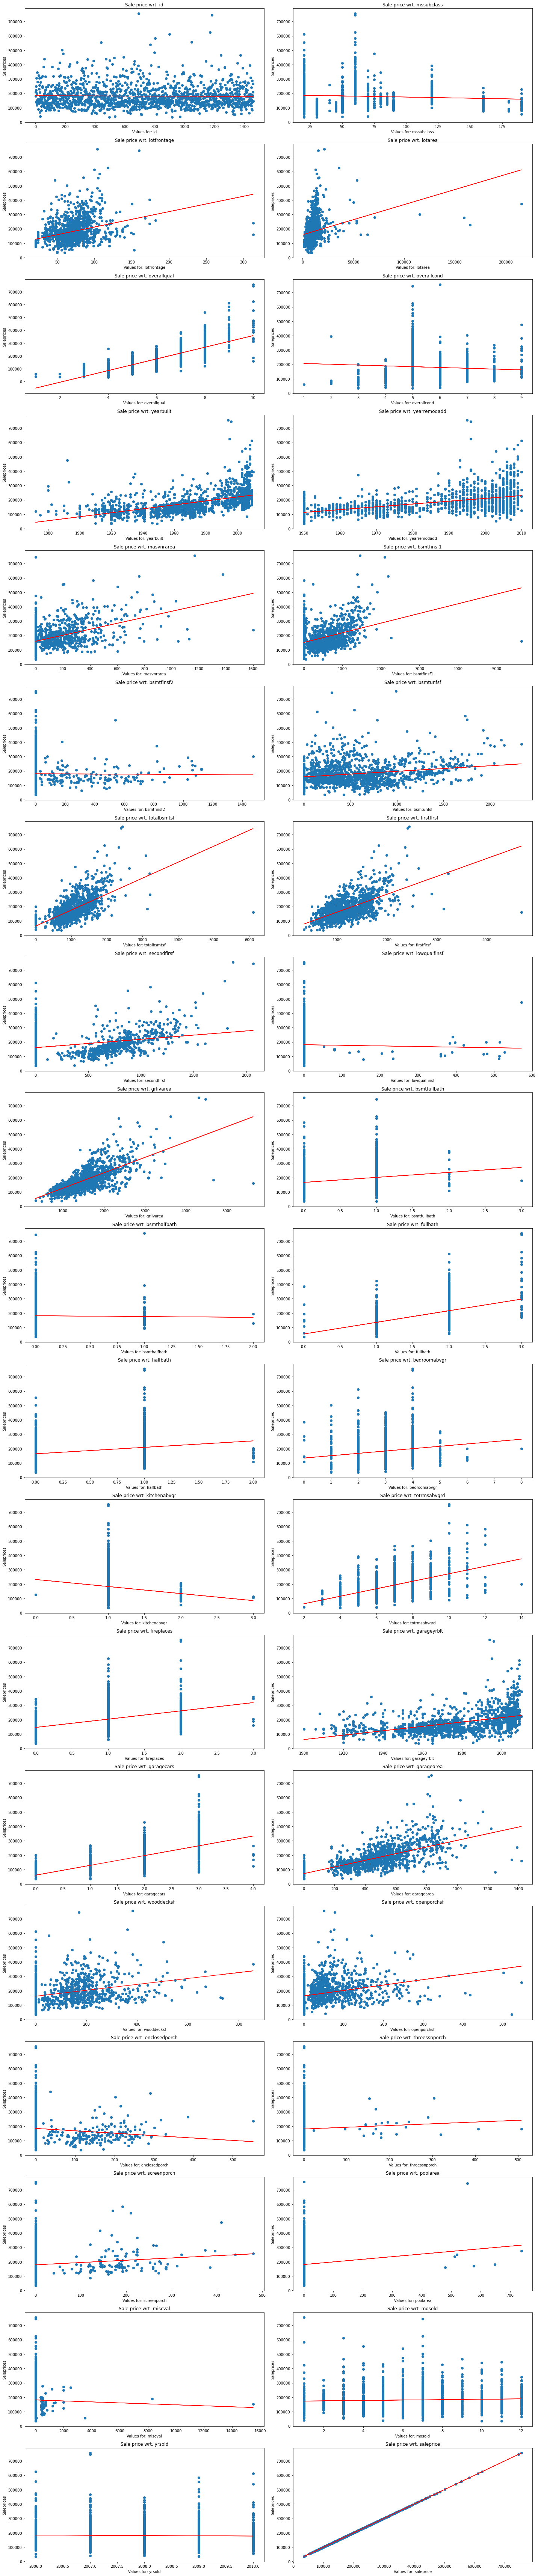

In [0]:
#show visualization of correlation to target, saleprice
saleprice = houseprice_data['saleprice']
plt.figure(figsize=(20,100))
for index, col in enumerate(numerical):
  m, b = np.polyfit(houseprice_data[col], saleprice, 1)
  plt.subplot(20,2,index + 1)
  plt.scatter(houseprice_data[col], saleprice)
  plt.plot(houseprice_data[col], m*houseprice_data[col] + b, color = 'red')
  plt.xlabel('Values for: {}'.format(col))
  plt.ylabel('Saleprices')
  plt.title('Sale price wrt. {}'.format(col))
plt.tight_layout()
plt.show()

We see the visualation of the correlations between the continous variables and the target. We will now use the corr() method to get a better numerical understanding of these correlations.

In [0]:
houseprice_data[numerical].corr()['saleprice'].sort_values(ascending = False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.474279
garageyrblt      0.467106
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
lotfrontage      0.310557
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: salepr

We see the values that have the strongest correlation, and will pick the top five strongest correlated.

In [0]:
numerical_features = ['overallqual', 'grlivarea', 'garagecars', 'garagearea']

Now lets do visualizations for the non-numerical data.

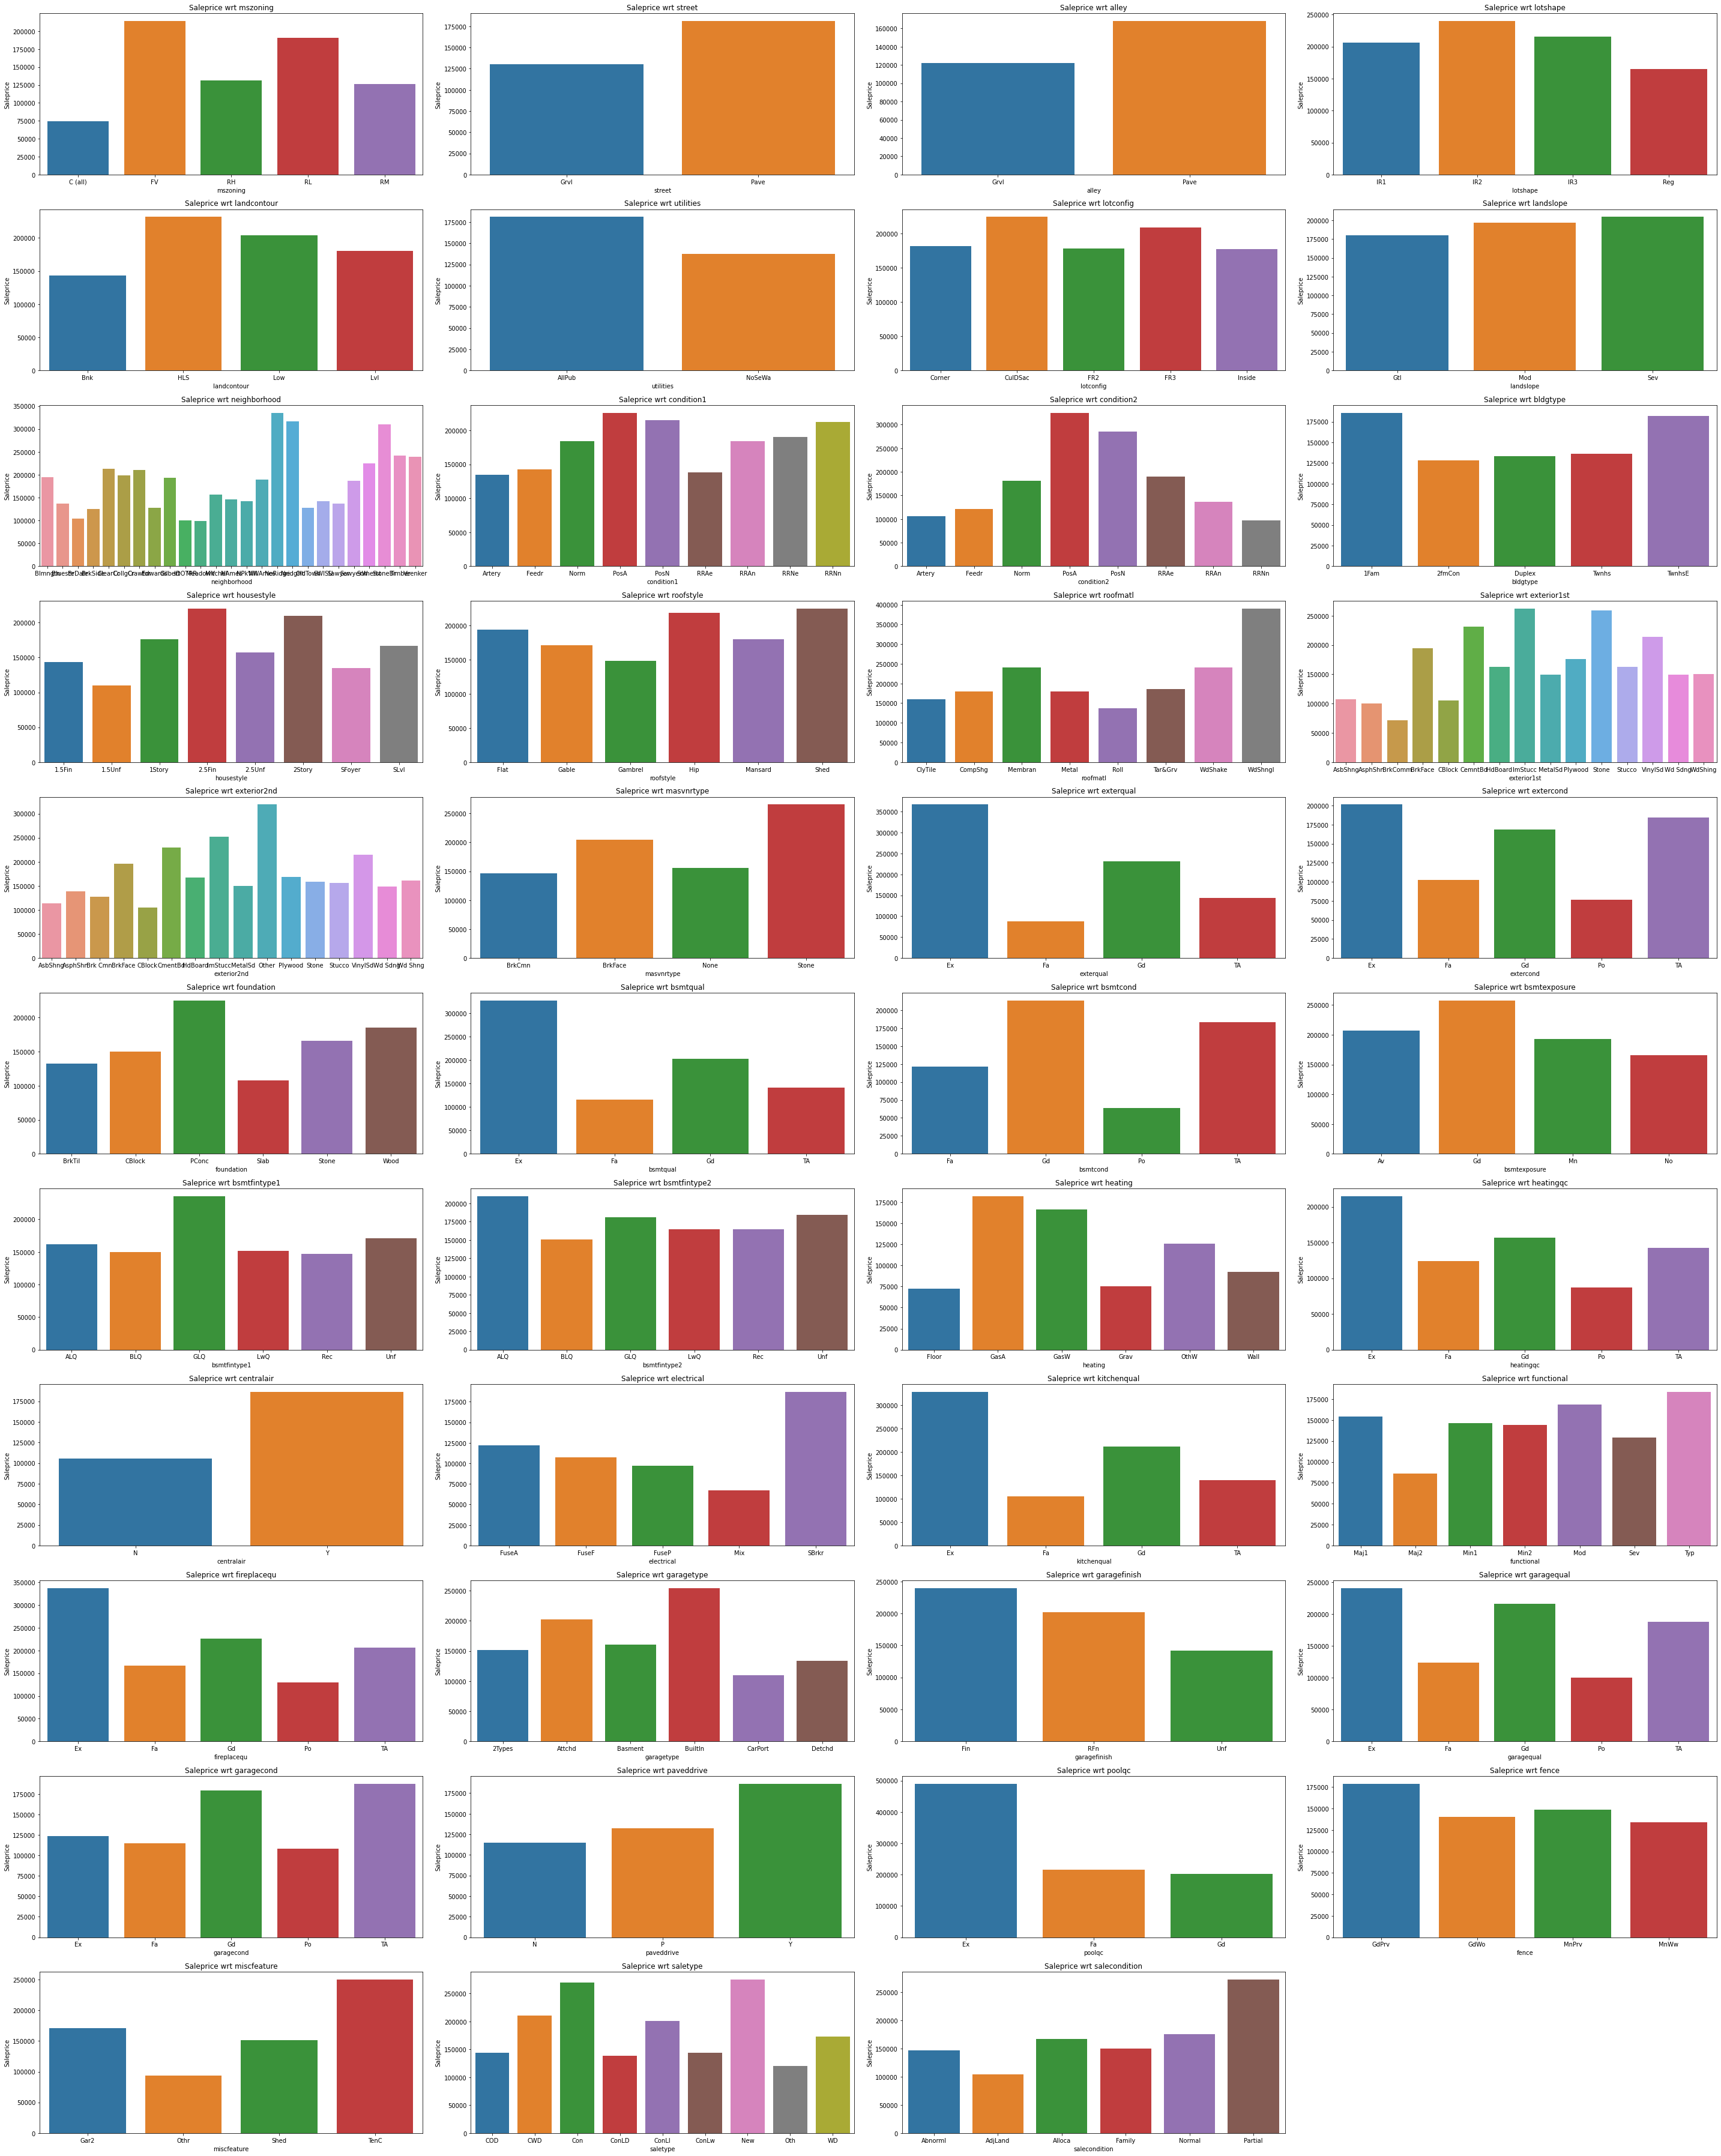

In [0]:
plt.figure(figsize=(40,50))
for index, col in enumerate(non_numerical):
  plt.subplot(11,4, index +1)
  sns.barplot(houseprice_data.groupby(col)['saleprice'].mean().index, houseprice_data.groupby(col)['saleprice'].mean())
  plt.xlabel(col)
  plt.ylabel('Saleprice')
  plt.title('Saleprice wrt {}'.format(col))
plt.tight_layout()
plt.show()

We now have visualizations for the categorical features, and we will now create dummies for the categorical values.

In [0]:
houseprice_data = pd.concat([houseprice_data, pd.get_dummies(houseprice_data.kitchenqual, prefix= 'kitchenqual', drop_first=True)], axis=1)
houseprice_data = pd.concat([houseprice_data, pd.get_dummies(houseprice_data.mszoning, prefix = 'mszoning', drop_first=True)], axis = 1)
dummy_columns = list(pd.get_dummies(houseprice_data.kitchenqual, prefix='kitchenqual', drop_first=True).columns)
dummy_columns = dummy_columns + list(pd.get_dummies(houseprice_data.mszoning, prefix = 'mszoning', drop_first= True).columns)

Now that we have our numerical data and our categorical data, lets create new features, by combining existing ones

In [0]:
houseprice_data['totalsf'] = houseprice_data.totalbsmtsf + houseprice_data.firstflrsf +houseprice_data.secondflrsf
houseprice_data['totalsf*quality'] = houseprice_data.totalsf * houseprice_data.overallqual
houseprice_data['lotarea*overallcond'] = houseprice_data.lotarea * houseprice_data.overallcond

Now that all the features have been prepared we can begin creating our models.


In [0]:
Y = np.log1p(houseprice_data.saleprice)
features = dummy_columns + numerical_features + ['totalsf', 'totalsf*quality', 'lotarea*overallcond']
X = houseprice_data[features]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = .2, random_state = 465)

We wil first use OLS to model the data

In [0]:
X = sm.add_constant(X)
results = sm.OLS(Y,X).fit()
print(results.summary())
X = houseprice_data[features]

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     582.8
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        15:26:20   Log-Likelihood:                 651.34
No. Observations:                1460   AIC:                            -1273.
Df Residuals:                    1445   BIC:                            -1193.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.1075    

Now we will employ a standard Linear Regression Model

In [0]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8486784781935319
-----Test set statistics-----
R-squared of the model in the test set is: 0.8461456748842462
Mean absolute error of the prediction is: 0.11736526774814299
Mean squared error of the prediction is: 0.025654539264712256
Root mean squared error of the prediction is: 0.16017034452329887
Mean absolute percentage error of the prediction is: 0.9807525138703378


In [0]:
alpha_values = [np.power(10.0,p) for p in np.arange(-10,40,1)]
ridgeregr = RidgeCV(alphas= alpha_values, cv = 5)
ridgeregr.fit(X_train, y_train)
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8481691121176361
-----Test set statistics-----
R-squared of the model on the test set is: 0.8412593520099317
Mean absolute error of the prediction is: 0.11835394304432886
Mean squared error of the prediction is: 0.026469312342718657
Root mean squared error of the prediction is: 0.16269392226730123
Mean absolute percentage error of the prediction is: 0.9897665594430104


In [0]:
lassoregr = LassoCV(alphas=alpha_values, cv = 5)
lassoregr.fit(X_train, y_train)
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8485016501908385
-----Test set statistics-----
R-squared of the model on the test set is: 0.843357042057114
Mean absolute error of the prediction is: 0.11794955196507889
Mean squared error of the prediction is: 0.02611953165478451
Root mean squared error of the prediction is: 0.16161538186318933
Mean absolute percentage error of the prediction is: 0.9860864265006767


In [0]:
elasticregr = ElasticNetCV(alphas= alpha_values, cv = 5)
elasticregr.fit(X_train, y_train)
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8486082225550626
-----Test set statistics-----
R-squared of the model on the test set is: 0.8444254728146108
Mean absolute error of the prediction is: 0.11773356169544504
Mean squared error of the prediction is: 0.025941375474909795
Root mean squared error of the prediction is: 0.1610632654422162
Mean absolute percentage error of the prediction is: 0.9841165336193345


It would seem that all the models have roughly the same adjusted r-squared value, around .818. However, taking a look at the mean squared error values, the OLS method provides the best results.

Next we will create a new pandas DataFrame with additional features that can be added to the model.

First we will load the data, prefrom data exploration, then choose the features we wouldl like to add.

In [0]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/johnadrian45/John-s-Projects/master/data.csv')

raw_data.info()
raw_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


We have loaded a new dataset with new features that could possibly be used in the model. We will prefrom the same procedures as above, but utizling this new data set to affect outcomes


In [0]:
print(houseprice_data.isna().sum())

id                     0
mssubclass             0
mszoning               0
lotfrontage            0
lotarea                0
                      ..
mszoning_RL            0
mszoning_RM            0
totalsf                0
totalsf*quality        0
lotarea*overallcond    0
Length: 91, dtype: int64


There are no missing values, split the data into numerical and non numerical and explore.

In [0]:
numerical_raw = []
non_numerical_raw = []
for col in raw_data:
  if raw_data[col].dtypes == 'object':
    non_numerical_raw.append(col)
  else:
    numerical_raw.append(col)

if (len(numerical_raw) + len(non_numerical_raw)) == raw_data.shape[1]:
  print('Seperation successful')

Seperation successful


In our new data set we have well over 4000 records, so a random sample will be taken of all the features and add them to houseprice_data dataframe. We will then interpolate for missing values since this is time series data.

In [0]:
# radomly select 1460 samples from new data to be used in our saleprice prediction, which has 1460 values
# add saleprice to our new data set, for visualization and correlation
raw_data = raw_data.sample(n = 1460, random_state= 465)
houseprice_data = pd.concat([raw_data, houseprice_data], axis=1)

In [0]:
for col in numerical_raw:
  houseprice_data.loc[:,col] = houseprice_data.loc[:,col].interpolate()
for col in features:
  houseprice_data.loc[:,col] = houseprice_data.loc[:,col].interpolate()

houseprice_data.isna().sum()


date                   1009
price                     0
bedrooms                  0
bathrooms                 0
sqft_living               0
                       ... 
mszoning_RL               0
mszoning_RM               0
totalsf                   0
totalsf*quality           0
lotarea*overallcond       0
Length: 109, dtype: int64

Both data sets have 'street' in the features. Street will be used in neither of the models so it can be dropped for ease of use.

In [0]:
houseprice_data = houseprice_data.drop('street', axis=1)
houseprice_data['street'] = raw_data.street

We will create visualizations using the new features from the new dataset

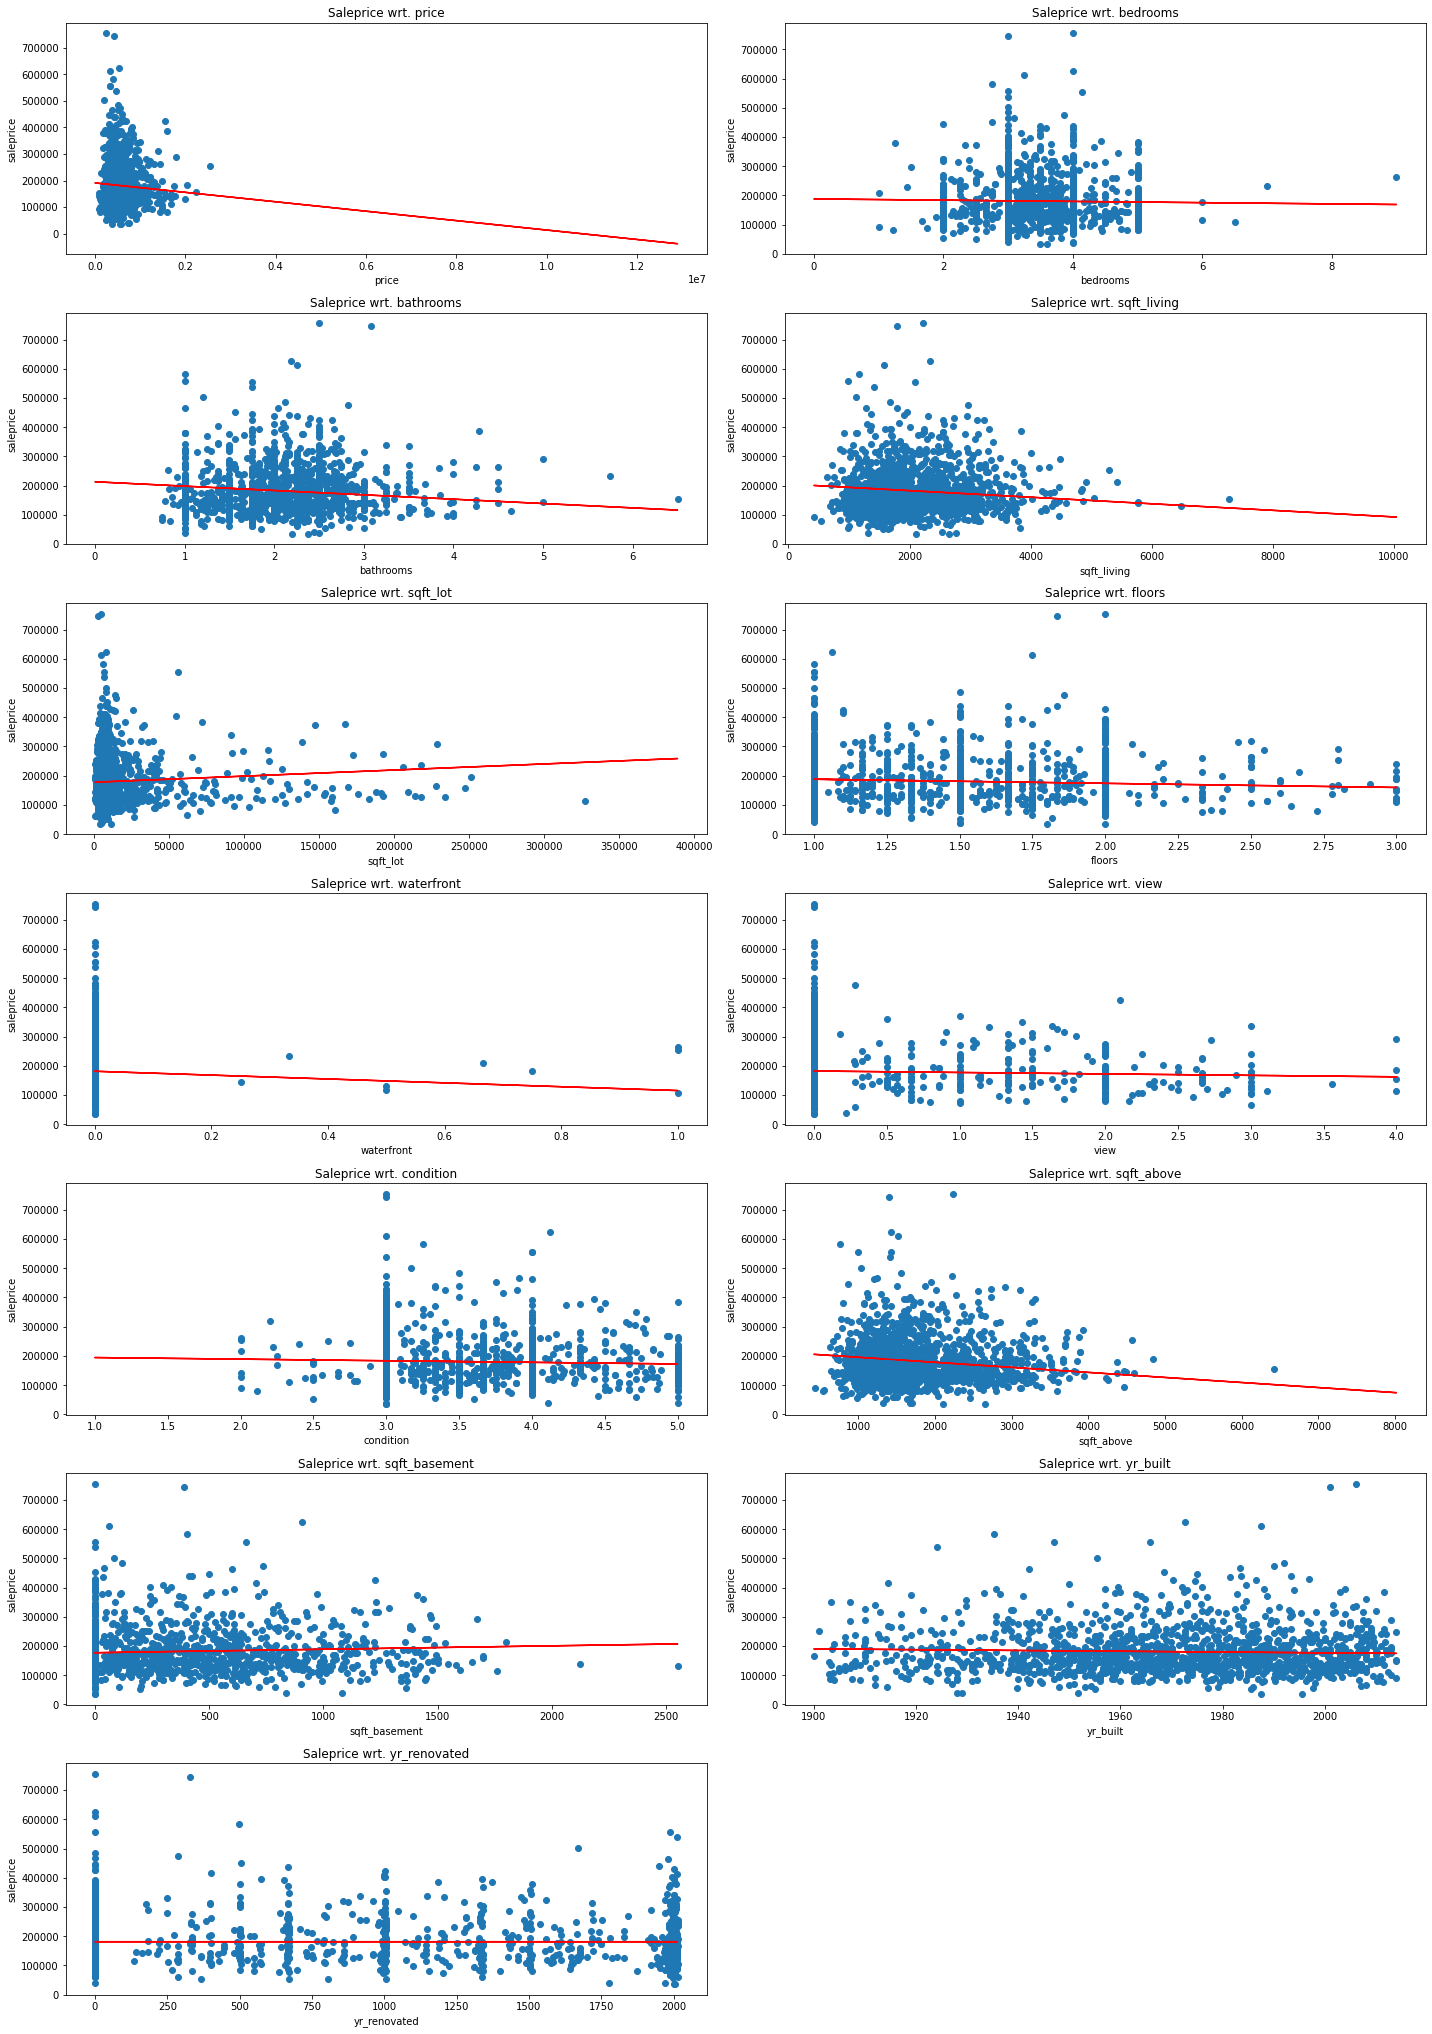

In [0]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) -np. mean(xs*ys)) /
         ((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    
    b = np.mean(ys) - m*np.mean(xs)
    
    return m, b

plt.figure(figsize=(20,40))
for index, col in enumerate(numerical_raw):
  m, b = best_fit_slope_and_intercept(houseprice_data[col], houseprice_data['saleprice'])
  plt.subplot(10,2, index + 1)
  plt.scatter(houseprice_data[col], houseprice_data['saleprice'])
  plt.plot(houseprice_data[col], m*houseprice_data[col] + b, color = 'red')
  plt.xlabel(col)
  plt.ylabel('saleprice')
  plt.title('Saleprice wrt. {}'.format(col))

plt.tight_layout()
plt.show()

Above we have the visualizations of correlation with saleprice. Below we have the numerical represenetation. We see that bedrooms has the strongest correlation with saleprice, therefore we will use that as one of our features

In [0]:
numerical_raw.append('saleprice')
houseprice_data[numerical_raw].corr()['saleprice']

price           -0.002477
bedrooms         0.007449
bathrooms        0.010632
sqft_living      0.002203
sqft_lot        -0.019612
floors          -0.011262
waterfront       0.008684
view            -0.029556
condition       -0.023861
sqft_above      -0.009825
sqft_basement    0.020940
yr_built         0.011716
yr_renovated    -0.014774
saleprice        1.000000
Name: saleprice, dtype: float64

We will now create visualizations for the categorical featurs in the new dataset to see how they correlate with the target 'saleprice'.

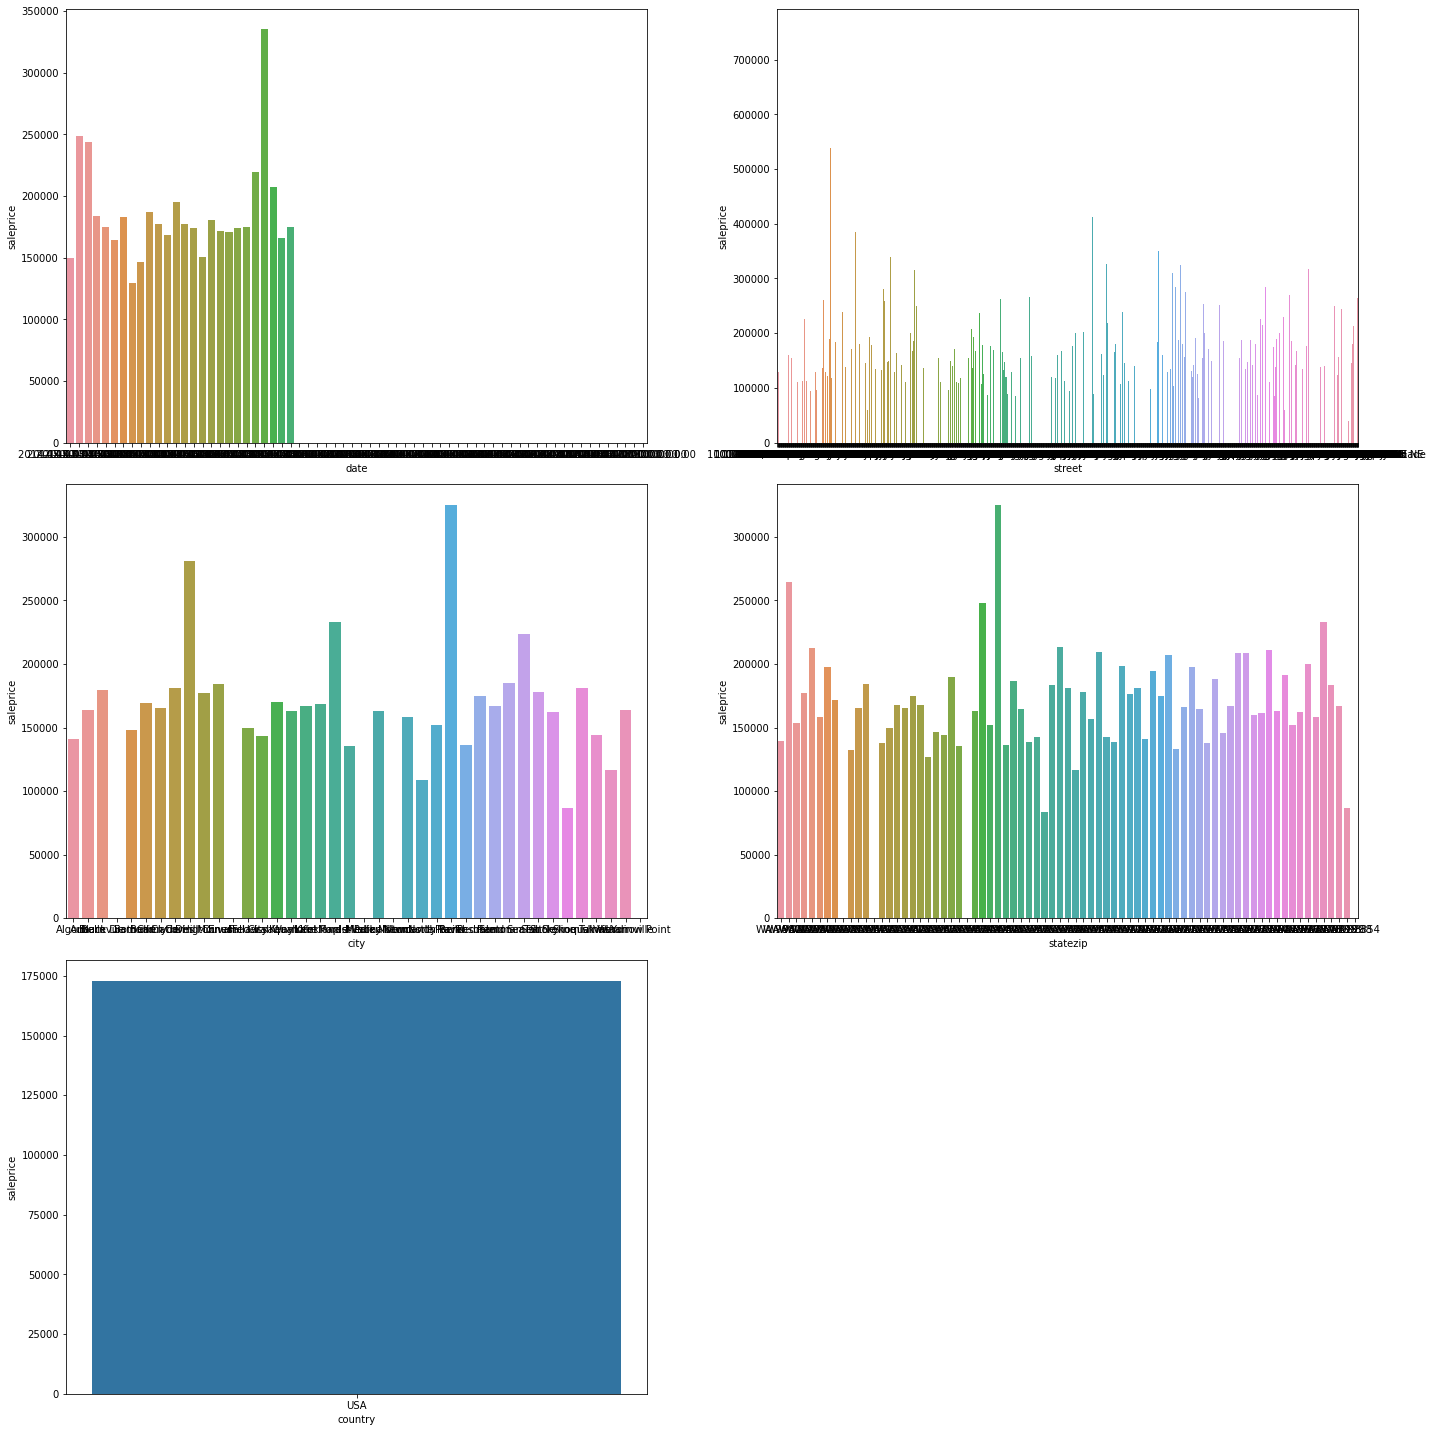

In [0]:
numerical_features = ['bedrooms', 'condition']
plt.figure(figsize=(20,20))
for index, col in enumerate(non_numerical_raw):
  plt.subplot(3,2,index + 1)
  sns.barplot(houseprice_data.groupby(col)['saleprice'].mean().index, houseprice_data.groupby(col)['saleprice'].mean())
plt.tight_layout()
plt.show()

We now select the city categorical variable and get dummies for that feature, we add that to our raw_data and create a list of new features to add to our model.

In [0]:
houseprice_data = pd.concat([houseprice_data, pd.get_dummies(raw_data.city, prefix= 'city', drop_first=True)], axis=1)
dummy_columns = list(pd.get_dummies(raw_data.city, prefix= 'city', drop_first= True).columns)

We now fill in the missing values in the newly concatenated housprice_data

In [0]:
for col in dummy_columns:
  houseprice_data.loc[:,col] = houseprice_data.loc[:,col].interpolate()

We will now fill in the missing values for 'saleprice' after the concatenation has been done.

In [0]:
houseprice_data['saleprice'] = houseprice_data.saleprice.interpolate()
houseprice_data.saleprice.isna().sum()


0

In the first half of this code we have features selected from the 'houseprices' dataframe. We now have new features that have been explored and chosen from newly added data. These newly added features will be added to our existing model and tested for performance using OLS, Linear Regression, Lasso Regression, Ridge Regression, and ElasticNet Regression. We will choose which models prefroms the best.


In [0]:
features = features + numerical_features + dummy_columns
X = houseprice_data[features]
Y = houseprice_data.saleprice
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = .2, random_state = 465)

Run model using OLS

In [0]:
Y = houseprice_data.saleprice
X = sm.add_constant(X)
results = sm.OLS(Y,X).fit()
print(results.summary())

features = ['kitchenqual_Fa', 'kitchenqual_Gd', 'kitchenqual_TA', 'mszoning_FV', 'mszoning_RH', 'mszoning_RL',
            'overallqual', 'grlivarea', 'garagecars', 'totalsf',
            'totalsf*quality', 'lotarea*overallcond', 'condition']

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     193.1
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        15:27:39   Log-Likelihood:                -28715.
No. Observations:                2469   AIC:                         5.754e+04
Df Residuals:                    2413   BIC:                         5.787e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.046e+

Run new model using Linear Regression.

In [0]:
X = houseprice_data[features]
Y = houseprice_data.saleprice
lrm = LinearRegression()
lrm.fit(X_train,y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model in the training set is: 0.8214552889164363
-----Test set statistics-----
R-squared of the model in the test set is: 0.7851703225676281
Mean absolute error of the prediction is: 15175.592424034534
Mean squared error of the prediction is: 925873075.5085988
Root mean squared error of the prediction is: 30428.162539144534
Mean absolute percentage error of the prediction is: 9.193082384035646


Run new model using RidgeCV Regression.


In [0]:
alpha_values = [np.power(10.0,p) for p in np.arange(-10,40,1)]
ridgeregr = RidgeCV(alphas= alpha_values, cv = 5)
ridgeregr.fit(X_train, y_train)
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.7758980846629718
-----Test set statistics-----
R-squared of the model on the test set is: 0.760270428090738
Mean absolute error of the prediction is: 14884.64913839501
Mean squared error of the prediction is: 1033186655.9910498
Root mean squared error of the prediction is: 32143.220995896627
Mean absolute percentage error of the prediction is: 9.077893713122156


Run new model using LassoCV Regression

In [0]:
lassoregr = LassoCV(alphas=alpha_values, cv = 5)
lassoregr.fit(X_train, y_train)
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.7660262050323843
-----Test set statistics-----
R-squared of the model on the test set is: 0.7437675612594143
Mean absolute error of the prediction is: 14367.94518332939
Mean squared error of the prediction is: 1104310721.5784795
Root mean squared error of the prediction is: 33231.17093300324
Mean absolute percentage error of the prediction is: 8.640942653921053


Run model using ElasticNetCV regression.

In [0]:
elasticregr = ElasticNetCV(alphas= alpha_values, cv = 5)
elasticregr.fit(X_train, y_train)
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.7692261507366234
-----Test set statistics-----
R-squared of the model on the test set is: 0.7471584610209416
Mean absolute error of the prediction is: 14548.57975356611
Mean squared error of the prediction is: 1089696619.7073126
Root mean squared error of the prediction is: 33010.553156639355
Mean absolute percentage error of the prediction is: 8.778807778679075


After adding the new data we see that a standard linear regression method is the best fit.